In [150]:
import pandas as pd          
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
import matplotlib
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import array
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats

In [151]:
df = pd.read_csv('PRSA_data.csv')

df = df.drop(['Ir','No','Is'],axis = 1)

#Changing the column names
cnames = list(df.columns)

#Drop the first row 
df = df[24:]

df.dtypes

df.reset_index(inplace = True)
df = df.drop(['index'], axis = 1)

df_new = df[['year', 'month', 'day', 'hour']]
df_new['date'] = pd.to_datetime(df_new)

df['date'] = df_new['date']

#Set the date as Index
df = df.set_index(df['date'],drop = False)
df = df.sort_index()

# df_cbwd = df['cbwd']
# df_cbwd['cbwd_mode'] = df_cbwd.resample("d").apply(lambda x: stats.mode(x)[0])

# df = df.resample('d').mean()
# df['cbwd'] = df_cbwd['cbwd_mode']

df['day_of_week'] = df.index.dayofweek

def weekend(row):
    if (row == 5) or (row == 6):
        return 1
    else:
        return 0

df['weekend'] = df['day_of_week'].apply(weekend)


mean = df['pm2.5'].min()
std_dev = df['pm2.5'].max() - df['pm2.5'].min()

for field in cnames:
    print(field, df[field].isna().sum())

df['pm2.5'] = df['pm2.5'].fillna(df['pm2.5'].mean())

df = pd.get_dummies(df, columns = ['cbwd'] )    

df['PM2.5'] = df['pm2.5']
df = df.drop(['pm2.5'], axis = 1)

df = df.drop(['hour', 'date'], axis = 1)

cnames = list(df.columns)

year 0
month 0
day 0
hour 0
pm2.5 2043
DEWP 0
TEMP 0
PRES 0
cbwd 0
Iws 0


In [152]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,-16,-4.0,1020.0,1.79,5,1,0,0,1,0,129.0
2010-01-02 01:00:00,2010,1,2,-15,-4.0,1020.0,2.68,5,1,0,0,1,0,148.0
2010-01-02 02:00:00,2010,1,2,-11,-5.0,1021.0,3.57,5,1,0,0,1,0,159.0
2010-01-02 03:00:00,2010,1,2,-7,-5.0,1022.0,5.36,5,1,0,0,1,0,181.0
2010-01-02 04:00:00,2010,1,2,-7,-5.0,1022.0,6.25,5,1,0,0,1,0,138.0


In [153]:
df = df.resample('d').mean()

In [154]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02,2010.0,1.0,2.0,-8.500000,-5.125000,1024.750000,24.860000,5.0,1.0,0.000,0.000000,1.00,0.000000,145.958333
2010-01-03,2010.0,1.0,3.0,-10.125000,-8.541667,1022.791667,70.937917,6.0,1.0,0.000,0.166667,0.75,0.083333,78.833333
2010-01-04,2010.0,1.0,4.0,-20.875000,-11.500000,1029.291667,111.160833,0.0,0.0,0.000,1.000000,0.00,0.000000,31.333333
2010-01-05,2010.0,1.0,5.0,-24.583333,-14.458333,1033.625000,56.920000,1.0,0.0,0.375,0.583333,0.00,0.041667,42.458333
2010-01-06,2010.0,1.0,6.0,-23.708333,-12.541667,1033.750000,18.511667,2.0,0.0,0.500,0.416667,0.00,0.083333,56.416667


In [155]:
df = df.iloc[:-2,:]

In [156]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

for field in cnames:
	df[field] = (df[field] - df[field].min())/(df[field].max() - df[field].min())
        

# choose a number of time steps
n_steps_in, n_steps_out = 15, 4

X, y = split_sequences(df.values, n_steps_in, n_steps_out)

X_test, y_test = X[-1], y[-1]

for i in range(n_steps_out):
	X = np.delete(X, X.shape[0] - 1, 0)
	y = np.delete(y, y.shape[0] - 1, 0)

n_features = X.shape[2]
X_svr = X[:,:,0]

In [157]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# regr_multirf = MultiOutputRegressor(SVR(kernel='rbf'))

regr_multirf = MultiOutputRegressor(estimator=SVR(C = 12.0, cache_size=200, coef0=0.0, degree=5,
                                   epsilon=0.05, gamma= 'scale', kernel='rbf',
                                   max_iter=-1, shrinking=True, tol=0.001,
                                   verbose=False), n_jobs=None)
regr_multirf.fit(X_svr, y)

MultiOutputRegressor(estimator=SVR(C=12.0, cache_size=200, coef0=0.0, degree=5,
                                   epsilon=0.05, gamma='scale', kernel='rbf',
                                   max_iter=-1, shrinking=True, tol=0.001,
                                   verbose=False),
                     n_jobs=None)

In [158]:
X_test.shape

(15, 13)

In [159]:
X_test = X_test.reshape((1, n_steps_in, n_features))
X_test_new = X_test[:,:,0]
yhat = regr_multirf.predict(X_test_new)

In [160]:
print(X_test_new.shape)
print(yhat.shape)

(1, 15)
(1, 4)


In [161]:
print(yhat.shape)
print(y_test.shape)

(1, 4)
(4,)


In [162]:
X.shape

(1802, 15, 13)

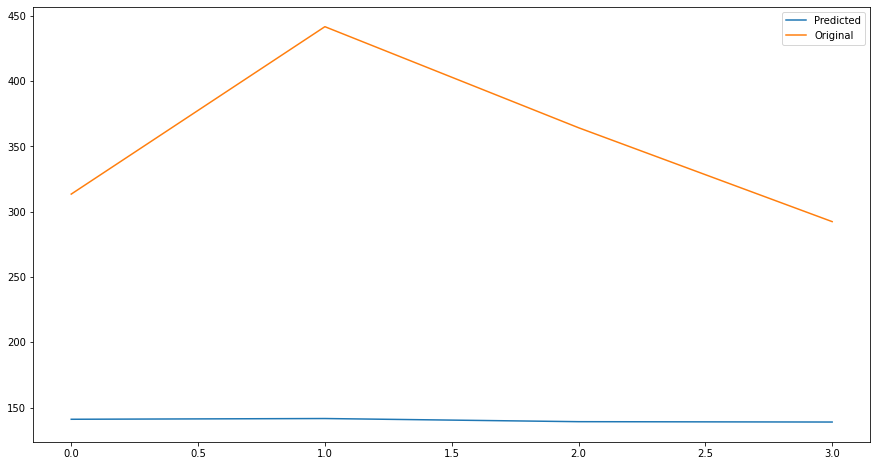

In [163]:
#Setting default Plot Size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,8

# fig, ax = plt.subplots()
plt.plot((yhat[0]*std_dev)+mean, label = 'Predicted')
plt.plot((y_test*std_dev)+mean, label = 'Original')
plt.legend()
plt.show()

In [164]:
x_ann = []
counter = 0
for inp_val in X:
 x_input_ann = inp_val.reshape((1, n_steps_in,n_features))
 x_input_ann = x_input_ann[:,:,0]
 y_newpred = regr_multirf.predict(x_input_ann)
 x_ann.append(y_newpred)
 counter = counter + 1
 #print(counter)

x_ann = array(x_ann)

In [165]:
x_ann_new = x_ann[:, 0, :]
x_ann_new.shape
x_ann_new = x_ann_new.reshape(x_ann_new.shape[0], x_ann_new.shape[1], -1)
y_new = y.reshape(y.shape[0], y.shape[1], -1)

In [166]:
from numpy import array
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
from keras.layers import GRU

In [167]:
model_auto = Sequential()
model_auto.add(Bidirectional(GRU(100, activation='relu', input_shape=(x_ann_new.shape[1], x_ann_new.shape[2]),return_sequences=True)))
model_auto.add(Bidirectional(GRU(50, activation='relu', return_sequences=True)))
model_auto.add(Bidirectional(GRU(10, activation='relu')))
model_auto.add(RepeatVector(x_ann_new.shape[1]))
model_auto.add(Bidirectional(GRU(100, activation='relu', return_sequences=True)))
model_auto.add(Bidirectional(GRU(50, activation='relu', return_sequences=True)))
model_auto.add(Bidirectional(GRU(10, activation='relu', return_sequences=True)))
model_auto.add(TimeDistributed(Dense(1)))
model_auto.compile(optimizer='adam', loss='mse')

In [168]:
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=50, verbose=1, mode='auto',
       restore_best_weights=True)
model_auto.fit(x_ann_new, y_new, callbacks=[monitor], validation_split = 0.1, verbose=1, epochs=2000)
#model_auto.save('Auto_improv.h5')

Train on 1621 samples, validate on 181 samples
Epoch 1/2000
1621/1621 [==============================] - 9s 6ms/step - loss: 0.0252 - val_loss: 0.0197
Epoch 2/2000
1621/1621 [==============================] - 2s 2ms/step - loss: 0.0204 - val_loss: 0.0210
Epoch 3/2000
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0203 - val_loss: 0.0198
Epoch 4/2000
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0200 - val_loss: 0.0195
Epoch 5/2000
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0197 - val_loss: 0.0210
Epoch 6/2000
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0198 - val_loss: 0.0194
Epoch 7/2000
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0198 - val_loss: 0.0194
Epoch 8/2000
1621/1621 [==============================] - 2s 2ms/step - loss: 0.0197 - val_loss: 0.0195
Epoch 9/2000
1621/1621 [==============================] - 2s 1ms/step - loss: 0.0196 - val_loss: 0.0198
Epoch 10/2000
162

In [169]:
y_test_new = y_test.reshape(y_test.shape[0], -1)


In [170]:
y_test_new = y_test_new.T
y_test_new = y_test_new.reshape(y_test_new.shape[0], y_test_new.shape[1], -1)
print(y_test_new.shape)
x_ann_new_input = array(y_test_new)
yhat_new = model_auto.predict(x_ann_new_input, verbose=1)


(1, 4, 1)
1/1 [==============================] - 1s 602ms/step


In [171]:
print(yhat_new.shape)
print(y_test_new.shape)


(1, 4, 1)
(1, 4, 1)


In [172]:
y_test_new_actual = (y_test_new[0]*std_dev)+mean
yhat_predicted = (yhat_new[0]*std_dev)+mean


In [173]:
print(yhat_predicted)
print(y_test_new_actual)


[[405.22946]
 [382.93307]
 [364.14886]
 [341.4311 ]]
[[313.39075108]
 [441.55703085]
 [364.20454409]
 [292.31590605]]


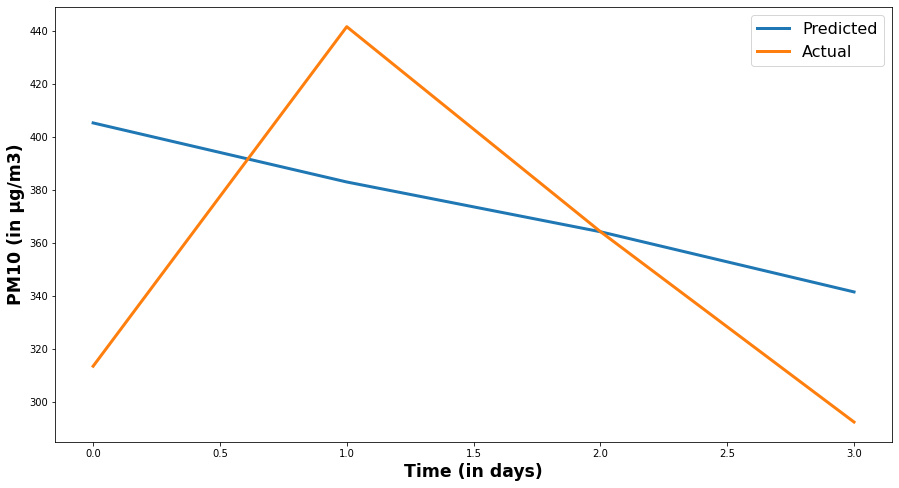

In [174]:
plt.plot((yhat_predicted),label = 'Predicted', linewidth = 3)
plt.plot((y_test_new_actual), label = 'Actual', linewidth = 3)
plt.xlabel('Time (in days)', fontsize = 'xx-large', fontweight = 'bold')
plt.ylabel('PM10 (in µg/m3)', fontsize = 'xx-large', fontweight = 'bold')
plt.legend(prop = {'size': 16})
plt.show()

In [175]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rms_new = sqrt(mean_squared_error(y_test_new_actual, yhat_predicted))
print(rms_new)

mse_new = mean_squared_error(y_test_new_actual, yhat_predicted)
print(mse_new)

mae_new = mean_absolute_error(y_test_new_actual, yhat_predicted)
print(mae_new)

mape_new = mean_absolute_percentage_error(y_test_new_actual, yhat_predicted)
print(mape_new)

59.75663455052569
3570.85537280508
49.908382773222584
14.849720024029223
